# Red Wine Quality

Kaggle link: https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009

## Preliminaries

In [206]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import wandb
import random
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./'): # '/kaggle/input'
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./simple-regression.ipynb
./winequality-red.csv
./wandb/debug-internal.log
./wandb/debug-cli.lorenzozanolin.log
./wandb/debug.log
./wandb/run-20231013_152213-1mdmbnvn/run-1mdmbnvn.wandb
./wandb/run-20231013_152213-1mdmbnvn/logs/debug-internal.log
./wandb/run-20231013_152213-1mdmbnvn/logs/debug.log
./wandb/run-20231013_152213-1mdmbnvn/files/requirements.txt
./wandb/run-20231013_152213-1mdmbnvn/files/output.log
./wandb/run-20231013_152213-1mdmbnvn/files/config.yaml
./wandb/run-20231013_152213-1mdmbnvn/files/wandb-metadata.json
./wandb/run-20231013_153847-h2jvr2b3/run-h2jvr2b3.wandb
./wandb/run-20231013_153847-h2jvr2b3/logs/debug-internal.log
./wandb/run-20231013_153847-h2jvr2b3/logs/debug.log
./wandb/run-20231013_153847-h2jvr2b3/files/requirements.txt
./wandb/run-20231013_153847-h2jvr2b3/files/output.log
./wandb/run-20231013_153847-h2jvr2b3/files/config.yaml
./wandb/run-20231013_153847-h2jvr2b3/files/wandb-summary.json
./wandb/run-20231013_153847-h2jvr2b3/files/wandb-metadata.json
./wand

First, we need to import Pytorch

In [207]:
import torch
from torch import nn
from torch import optim
from torch.utils import data
from sklearn.model_selection import train_test_split
#import wandb
#wandb.init(project="simple_regression")

## Data Processing

In [208]:
train_data = pd.read_csv('./winequality-red.csv')    #'/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv'
train_data.head()
train_data.shape

(1599, 12)

We need to separate features from target

In [209]:
n_train = train_data.shape[0]   #rows number
all_features = train_data.iloc[:, 0:-1] #features excluding the last column (quality), which is the label => features are X
#trains_labels   #labels representing the quality of the wine

Then we normalize the values

In [210]:
all_features = all_features.apply(lambda x: (x - x.mean()) / (x.std())) #normalization

train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)   #create the tensor containing the features

trains_labels = train_data.quality.values.reshape(-1, 1)

trains_mean = trains_labels.mean()
trains_std = trains_labels.std()
trains_labels = (trains_labels - trains_mean) / trains_std  #normalization
train_labels = torch.tensor(trains_labels,          #tensor containing the normalized training labels
                            dtype=torch.float32)
train_labels.shape

torch.Size([1599, 1])

Finally, We split the training set in two parts: *training* and *test* set.

In [211]:
X_train,X_test,Y_train,Y_test = train_test_split(train_features,train_labels,test_size=0.25)

## Training

Initialize the weights and bias of the linear regression

In [212]:
n_features = train_features.shape[1] 
weights = torch.randn((n_features),requires_grad=True) # TODO, initialize a random tensor of weights, one weight for each feature
bias = torch.zeros(1, requires_grad=True)
#weights,bias

Some functions definitions

In [213]:
from matplotlib import pyplot as plt


def linreg(X, w, b):        #linear regression
    return torch.matmul(X, w) + b

def sgd(params, lr, batch_size):    #we will use stochastic GD
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
            
criterion = nn.MSELoss()    #the loss function will be mean squared error

def data_iter(batch_size, features, labels):    #to divide a single batch in multiple minibatches
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i +
                                                   batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

def print_result(y_true, y_pred):
    # Convert the input data to NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Create a scatter plot of expected vs. predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, c='b', label='Expected vs. Predicted')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], '--k', label='Perfectly Predicted')
    plt.xlabel('Expected')
    plt.ylabel('Predicted')
    plt.title('Expected vs. Predicted Values')
    plt.legend(loc='best')
    plt.show()
    

Training loop

In [214]:
# MINI BATCH, calculate for each round the derivative for each minibatch, and then sum up them together
num_iterations = 512
batch_size = 16
lr = 1e-3
print('Training loss:')
for i in range(num_iterations):
    for X, y in data_iter(batch_size, X_train, Y_train):    
        loss = squared_loss(linreg(X,weights,bias),y)    #calculate the prediction, i.e. X(train features) * weights +b; then the loss w.r.t. labels
        loss.sum().backward() #derivate calc
        sgd([weights,bias],lr,batch_size)   #update weights
    with torch.no_grad():
        train_l = squared_loss(linreg(X, weights, bias), y)
        print(f'epoch {i + 1}, loss {float(train_l.mean()):f}')
    

Training loss:
epoch 1, loss 3.734096
epoch 2, loss 8.689196
epoch 3, loss 15.980167
epoch 4, loss 2.603438
epoch 5, loss 1.516117
epoch 6, loss 1.697435
epoch 7, loss 2.738381
epoch 8, loss 4.732492
epoch 9, loss 0.875453
epoch 10, loss 0.533862
epoch 11, loss 1.357580
epoch 12, loss 0.825537
epoch 13, loss 0.839972
epoch 14, loss 0.634928
epoch 15, loss 1.986021
epoch 16, loss 0.264879
epoch 17, loss 1.233916
epoch 18, loss 0.767111
epoch 19, loss 0.238481
epoch 20, loss 0.330144
epoch 21, loss 0.734327
epoch 22, loss 0.321314
epoch 23, loss 1.599388
epoch 24, loss 1.392594
epoch 25, loss 0.939398
epoch 26, loss 0.508035
epoch 27, loss 0.545777
epoch 28, loss 0.581832
epoch 29, loss 0.676029
epoch 30, loss 1.281293
epoch 31, loss 0.338271
epoch 32, loss 0.369849
epoch 33, loss 1.894951
epoch 34, loss 0.479866
epoch 35, loss 0.485533
epoch 36, loss 0.778880
epoch 37, loss 0.784511
epoch 38, loss 0.248342
epoch 39, loss 0.416498
epoch 40, loss 0.706453
epoch 41, loss 0.261633
epoch 42,

## Testing

We need to calculate the loss also over the test set

In [215]:
# test on the test dataset
with torch.no_grad():
    test_l = 0
    for X, y in data_iter(batch_size, X_test, Y_test):
        test_l += squared_loss(linreg(X, weights, bias), y).sum()
    test_l /= len(X_test)
    print(f'loss on the test dataset {float(test_l):f}')

loss on the test dataset 0.304873


## Results

Finally, the obtained predictions are the following

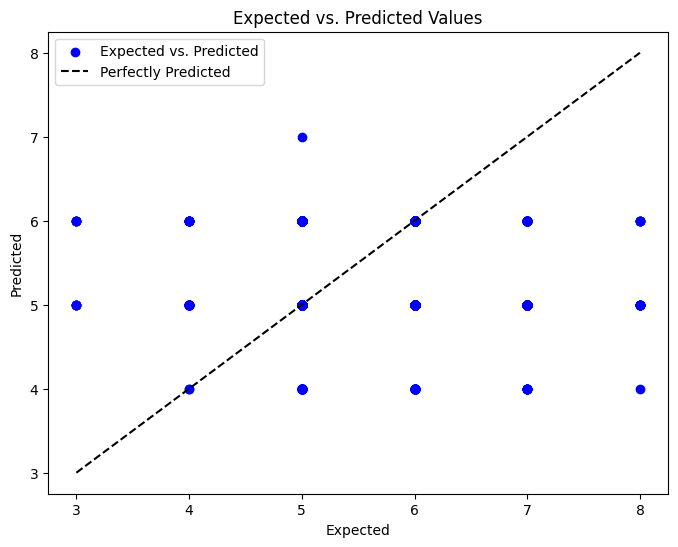

In [217]:
train_predictions = linreg(X_train,weights,bias)
train_predictions = torch.floor((train_predictions * trains_std) + trains_mean)  #denormalization + floor approximation

test_predictions = linreg(X_test,weights,bias)
test_predictions = torch.floor((test_predictions * trains_std) + trains_mean)  #denormalization + floor approximation

with torch.no_grad():
    print_result(torch.floor((train_labels * trains_std) + trains_mean),torch.cat((train_predictions,test_predictions),0))

#print(train_predictions,test_predictions)